# Classifying Philosophical Texts by School Using NLP and Machine Learning

### Can computational models accurately classify philosophical texts into their respective schools of thought?

This notebook explores the classification of philosophical texts into their respective schools using natural language processing (NLP) and machine learning techniques. Philosophical writings are often dense, abstract, and rich with specialized vocabulary, making manual categorization both time-consuming and challenging. By leveraging TF-IDF and Count Vectorizers alongside models such as Naive Bayes, Logistic Regression, Bagging, and Boosting, this analysis demonstrates how patterns in language can be used to distinguish between schools such as Phenomenology, German Idealism, Analytic, Feminism, and Stoicism. Additionally, topic modeling with LDA was used as an **exploratory tool** to visualize thematic patterns in the texts. The goal of this project is to assess whether computational tools can effectively categorize philosophical texts into their respective schools. If successful, this approach could facilitate faster, data-driven exploration of philosophical corpora and uncover patterns and themes across different schools, offering insights that may be valuable for philosophical research.

**Dataset Citation:**  
Alizadeh, K. (2019). *History of Philosophy* [Data set]. Kaggle. Retrieved from https://www.kaggle.com/datasets/kouroshalizadeh/history-of-philosophy

## Load the Data

In [1]:
#pip install kaggle
#!pip install wordcloud
#!pip install contractions

In [2]:
#library imports

#eda and analysis 
import pandas as pd 
import numpy as np

#text preprocessing
import spacy
nlp = spacy.load("en_core_web_sm")
import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)
import contractions

#visualizations
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

#modeling and analysis
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import label_binarize

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/briannaklabunde/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
#import json
#import os
#import kaggle

#load API key 
#with open("/Users/briannaklabunde/Downloads/IOD Data Science & AI/Mini Project 3/kaggle.json", "r") as f:
#    kaggle_api = json.load(f)

#os.environ['KAGGLE_USERNAME'] = kaggle_api['username']
#os.environ['KAGGLE_KEY'] = kaggle_api['key']

#download dataset
#kaggle.api.dataset_download_files('kouroshalizadeh/history-of-philosophy', path='.', unzip=True)


In [4]:
df = pd.read_csv('/Users/briannaklabunde/Downloads/IOD Data Science & AI/Mini Project 3/philosophy_data.csv')

## Exploratory Data Analysis 

Original dataset had 13 schools and 360,808 rows. For this mini project I will select only 5 schools and 1000 samples from each school. 

In [5]:
#schools to keep 
schools_to_keep = ["analytic", "german_idealism", "phenomenology", "feminism", "stoicism"]

#filter the df to only include these schools
df_filtered = df[df['school'].isin(schools_to_keep)]

#sample 1000 rows per school
phil = (
    df_filtered
    .groupby('school', group_keys=False)
    .apply(
        lambda x: x.assign(school=x.name).sample(n=1000, random_state=42),
        include_groups=False
    )
    .reset_index(drop=True)
)

In [6]:
phil.sample(5)

,title,author,sentence_spacy,sentence_str,original_publication_date,corpus_edition_date,sentence_length,sentence_lowered,tokenized_txt,lemmatized_str,school
3565,Being And Time,Heidegger,With regard to what kind of beings do we speak...,With regard to what kind of beings do we speak...,1927,1996,72,with regard to what kind of beings do we speak...,"['with', 'regard', 'to', 'what', 'kind', 'of',...",with regard to what kind of being do -PRON- s...,phenomenology
4874,Meditations,Marcus Aurelius,A man cannot any whither retire better than to...,A man cannot any whither retire better than to...,170,2008,239,a man cannot any whither retire better than to...,"['man', 'cannot', 'any', 'whither', 'retire', ...",a man can not any whither retire better than ...,stoicism
383,Quintessence,Quine,"On refinement, the appeal to meanings gave way...","On refinement, the appeal to meanings gave way...",1950,2004,87,"on refinement, the appeal to meanings gave way...","['on', 'refinement', 'the', 'appeal', 'to', 'm...","on refinement , the appeal to meaning give wa...",analytic
3524,The Phenomenology Of Perception,Merleau-Ponty,Thus it is by giving up part of his spontaneit...,Thus it is by giving up part of his spontaneit...,1945,2002,275,thus it is by giving up part of his spontaneit...,"['thus', 'it', 'is', 'by', 'giving', 'up', 'pa...",thus -PRON- be by give up part of -PRON- spon...,phenomenology
3881,Being And Time,Heidegger,"This phenomenon, in which we recog nized a bas...","This phenomenon, in which we recog nized a bas...",1927,1996,130,"this phenomenon, in which we recog nized a bas...","['this', 'phenomenon', 'in', 'which', 'we', 'r...","this phenomenon , in which -PRON- recog nize ...",phenomenology


In [7]:
#see some examples of text from each school
pd.set_option('display.max_colwidth', None)
examples_df = phil.groupby('school').apply(lambda x: x.sample(1))[['title','author','sentence_str']]
examples_df

/var/folders/k8/2sb77b9n7fn3xkm1tlhng1mm0000gn/T/ipykernel_6847/1507671373.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  examples_df = phil.groupby('school').apply(lambda x: x.sample(1))[['title','author','sentence_str']]


,,title,author,sentence_str
school,,,,
analytic,360,Quintessence,Quine,Lan guage and science are rooted in what good scientific language eschews.
feminism,1557,The Second Sex,Beauvoir,"But first, what is a woman? '"
german_idealism,2225,Science Of Logic,Hegel,"The coming forth into concrete existence is therefore so immediate, that it is mediated only by the disappearing of the mediation."
phenomenology,3984,The Crisis Of The European Sciences And Phenomenology,Husserl,"Furthermore, transcendental philosophy, for essential reasons (which are perfectly clear from our systematic presentations), can never undergo the unnoticed transformation into a mere rexyn and thus into a process of depletion whereby what has become a technique retains only a hidden meaning one whose full depths, indeed, can be revealed only transcendentally."
stoicism,4224,Meditations,Marcus Aurelius,"Every particular nature hath content, when in its own proper course it speeds."


In [8]:
phil['school'].value_counts()

school
analytic           1000
feminism           1000
german_idealism    1000
phenomenology      1000
stoicism           1000
Name: count, dtype: int64

In [9]:
phil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   title                      5000 non-null   object
 1   author                     5000 non-null   object
 2   sentence_spacy             5000 non-null   object
 3   sentence_str               5000 non-null   object
 4   original_publication_date  5000 non-null   int64 
 5   corpus_edition_date        5000 non-null   int64 
 6   sentence_length            5000 non-null   int64 
 7   sentence_lowered           5000 non-null   object
 8   tokenized_txt              5000 non-null   object
 9   lemmatized_str             5000 non-null   object
 10  school                     5000 non-null   object
dtypes: int64(3), object(8)
memory usage: 429.8+ KB


In [10]:
#sentence_str and sentence_spacy are identical columns, don't need both 
(phil['sentence_str'] == phil['sentence_spacy']).all()

np.True_

In [11]:
#drop columns 
phil = phil.drop(columns = 'sentence_spacy')

In [12]:
#expand contractions on sentence_str column  

def expand_contractions(text):
    return contractions.fix(text)


In [13]:
phil['sentence_str'] = phil['sentence_str'].apply(expand_contractions)

In [14]:
#creating a lemmatized column which keeps pronouns, removes stops words and punctuation 

def lemmatize_sentence_clean(text):
    doc = nlp(text)
    lemmatized = []
    for token in doc:
        #keep pronouns
        word = token.text if token.lemma_ == "-PRON-" else token.lemma_
        #only keep words that are not stopwords or punctuation
        if word.lower() not in stop_words and word not in punctuation:
            lemmatized.append(word)
    return " ".join(lemmatized)


In [15]:
phil['lemmatized_clean'] = phil['sentence_str'].apply(lemmatize_sentence_clean)

In [16]:
# Remove stray "s" and "'s" showing up in word cloud
phil['lemmatized_clean'] = phil['lemmatized_clean'].apply(
    lambda text: " ".join([w for w in text.split() if w not in ["s", "'s"]])
)

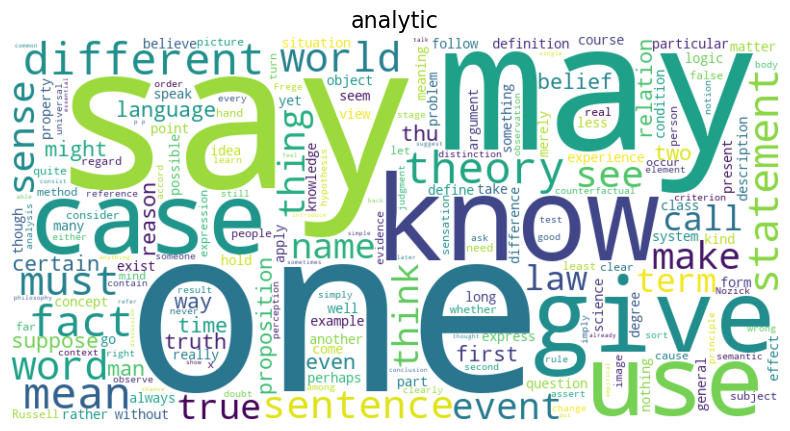

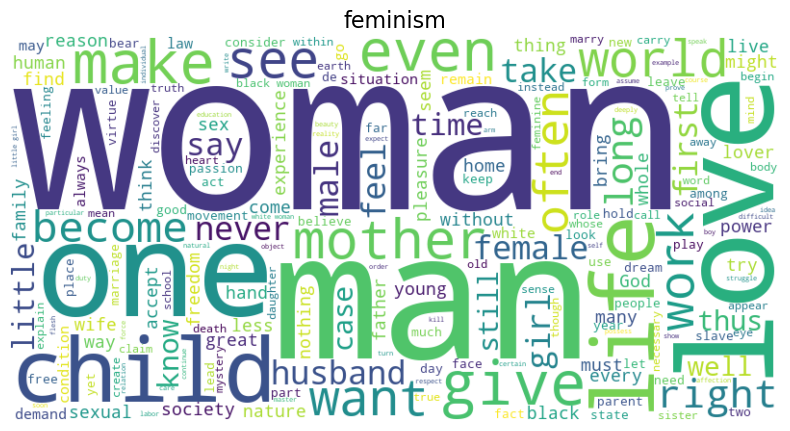

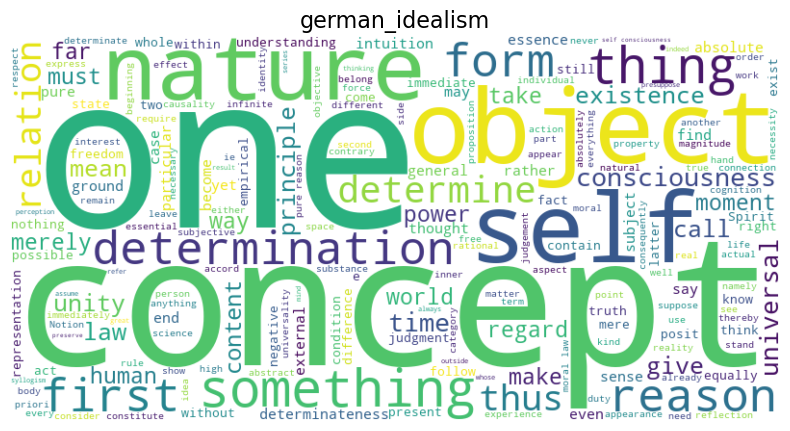

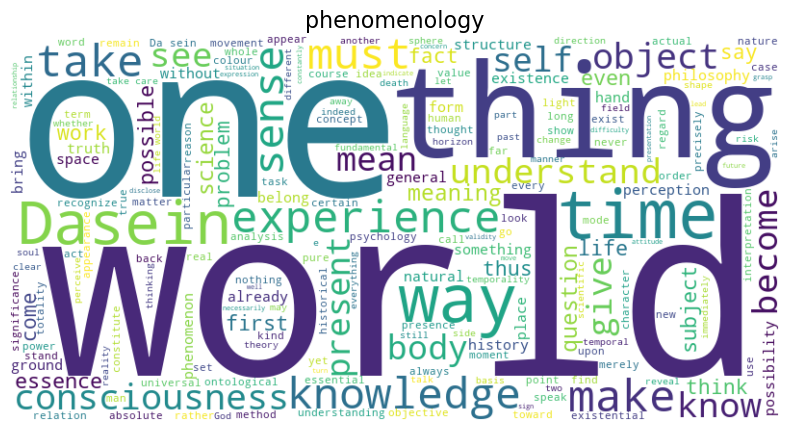

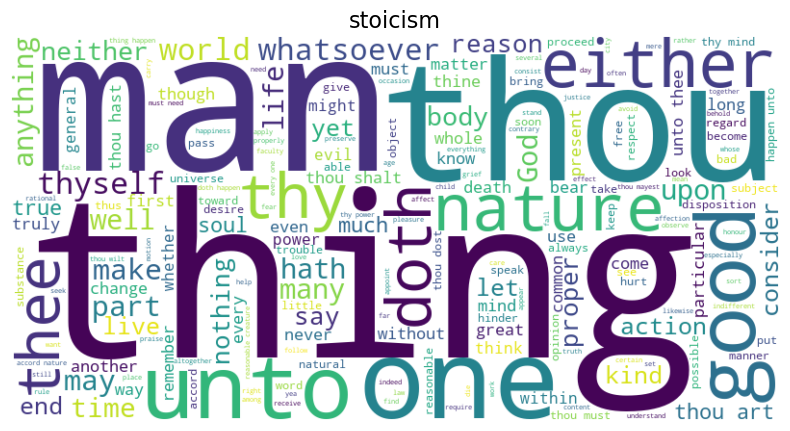

In [17]:
for school in phil['school'].unique():
    text = " ".join(phil[phil['school'] == school]['lemmatized_clean'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(school, fontsize=16)
    plt.show()

Each cloud includes the word 'one'

Analytic:
- sentence, statement, theory, know, different -- analytical philosophy emphasizes clarity, argumentation, and analysis of language
- absent of emotion unlike feminism, but very generlized language 

Feminism: 
- love, woman, child, life stand out -- strong topic and emotional focus
- clear, distinctive vocab, probably easy for the model to classify

German Idealism: 
- determination, concept, reason, object -- very abstract language
- could overlap with phenomenology since both use similar words

Phenomenology:
- thing, world, time, dasein -- focused on lived experience and being
- distinctic word, dasein, might help the model, but overall this cloud isn't super unique
- Dasein: means human existence -- literally “being there.” It describes the kind of being that humans are: the being that can question, interpret, and understand its own existence.

Stoicism:
- thy, though, soul, nature, good -- old-fashioned and moral tone
- old language should make this one easy for the model to classify

How seperable are the words used in each school? 

In [18]:
#document term matrix
vectorizer = CountVectorizer(
    max_df=0.75,   #ignore common words 
    min_df=10,     #ignores rare words 
    token_pattern=r'\b[a-zA-Z]{3,}\b',
    ngram_range= (1,2),
    stop_words='english')
dtm = vectorizer.fit_transform(phil['lemmatized_clean'])

#fit LDA
lda = LatentDirichletAllocation(n_components=5, random_state=42) #5 schools
lda.fit(dtm)

for i, topic in enumerate(lda.components_):
    print(f"Top words for topic #{i}:")
    print([vectorizer.get_feature_names_out()[index] for index in topic.argsort()[-10:]])
    print("\n")


Top words for topic #0:
['determination', 'word', 'use', 'universal', 'matter', 'present', 'sense', 'form', 'concept', 'reason']


Top words for topic #1:
['mind', 'doth', 'thee', 'good', 'thy', 'nature', 'unto', 'man', 'thou', 'thing']


Top words for topic #2:
['time', 'man', 'feel', 'case', 'come', 'make', 'world', 'life', 'child', 'love']


Top words for topic #3:
['hold', 'really', 'black', 'time', 'think', 'know', 'right', 'say', 'man', 'woman']


Top words for topic #4:
['way', 'nature', 'possible', 'question', 'experience', 'law', 'consciousness', 'self', 'object', 'world']




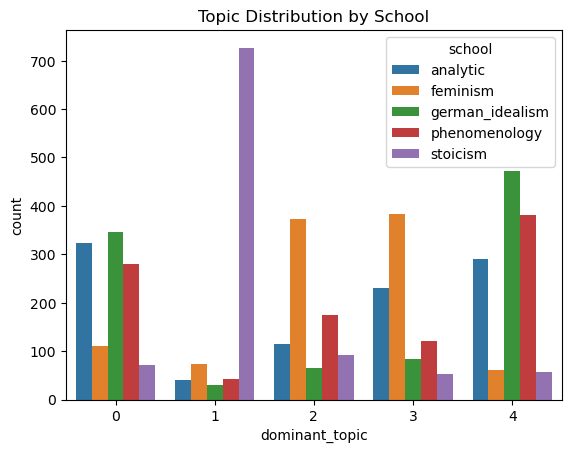

In [19]:
topic_values = lda.transform(dtm)
phil['dominant_topic'] = topic_values.argmax(axis=1)

sns.countplot(data=phil, x='dominant_topic', hue='school')
plt.title('Topic Distribution by School')
plt.show()

- stoicism is the most seperable
- as parameters change, feminism and german idealism seem to be more or less seperable
- phenomenology, analytics, and german idealism overlap a lot in their word distributions 

## Feature Engineering 

In [20]:
#define target and features 
X = phil['lemmatized_clean']
y = phil['school']

#split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Count Vectorizer (lemmatized tokens only)

In [21]:
#create a count vectorizer object
count_vect = CountVectorizer()

#learn vocab of all lemmatized tokens (stop words and punctuation removed) 
count_vect.fit(X_train)

#transform into document-term matrix
X_train_count = count_vect.transform(X_train)
X_test_count = count_vect.transform(X_test)

### TF-IDF (lemmatized tokens and n-gram)

In [22]:
%%time
#token level tf-idf
tfidf_vect = TfidfVectorizer(analyzer = 'word',
                             token_pattern=r'(?u)\b\w+\b',  # keep token boundaries as is 
                             lowercase=False,               # already lowercase
                             max_features=10000)

#fit train and transform train & test 
tfidf_vect.fit(X_train)

X_train_tfidf = tfidf_vect.transform(X_train)
X_test_tfidf  = tfidf_vect.transform(X_test)

CPU times: user 161 ms, sys: 6.37 ms, total: 168 ms
Wall time: 174 ms


In [23]:
%%time
#ngram level tf-idf
tfidf_vect_ngram = TfidfVectorizer(analyzer = 'word',
                                   token_pattern = r'(?u)\b\w+\b',
                                   ngram_range = (2, 3), #includes word groups of 2 and 3 
                                   max_features = 10000)

#fit train and transform train & test 
tfidf_vect_ngram.fit(X_train)
X_train_tfidf_ngram = tfidf_vect_ngram.transform(X_train)
X_test_tfidf_ngram  = tfidf_vect_ngram.transform(X_test)

CPU times: user 519 ms, sys: 17.2 ms, total: 536 ms
Wall time: 541 ms


## Modeling

In [24]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid):
    #fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)

    #predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)

    return accuracy_score(predictions, y_test)

In [25]:
#collect results in a df
results = pd.DataFrame(columns = ['Count Vectors',
                                  'Lemmatized Tokens TF-IDF',
                                  'N-Gram Vectors'])

### Naive Bayes

In [26]:
%%time
#NB on count vectors
accuracy1 = train_model(MultinomialNB(), X_train_count, y_train, X_test_count)
print('NB, Count Vectors    : %.4f\n' % accuracy1)

NB, Count Vectors    : 0.7370

CPU times: user 24.1 ms, sys: 4.14 ms, total: 28.2 ms
Wall time: 34.8 ms


In [27]:
%%time
#NB on lemmatized tokens TF IDF vectors
accuracy2 = train_model(MultinomialNB(), X_train_tfidf, y_train, X_test_tfidf)
print('NB, Lemmatized Tokens TF-IDF : %.4f\n' % accuracy2)

NB, Lemmatized Tokens TF-IDF : 0.7380

CPU times: user 24.8 ms, sys: 3.71 ms, total: 28.5 ms
Wall time: 30.6 ms


In [28]:
%%time
#NB on ngram TF IDF vectors
accuracy3 = train_model(MultinomialNB(), X_train_tfidf_ngram, y_train, X_test_tfidf_ngram)
print('NB, N-Gram Vectors   : %.4f\n' % accuracy3)

NB, N-Gram Vectors   : 0.4180

CPU times: user 20.9 ms, sys: 3.32 ms, total: 24.2 ms
Wall time: 23 ms


In [29]:
results.loc['Naïve Bayes'] = {
    'Count Vectors': accuracy1,
    'Lemmatized Tokens TF-IDF': accuracy2,
    'N-Gram Vectors': accuracy3}

### Logistic Regression

In [30]:
%%time
#LR on count vectors
accuracy1 = train_model(LogisticRegression(solver = 'lbfgs', max_iter = 350), X_train_count, y_train, X_test_count)
print('LR, Count Vectors    : %.4f\n' % accuracy1)

LR, Count Vectors    : 0.7150

CPU times: user 806 ms, sys: 24.9 ms, total: 831 ms
Wall time: 458 ms


In [31]:
%%time
#LR on lemmatized tokens TF IDF vectors
accuracy2 = train_model(LogisticRegression(solver = 'lbfgs', max_iter = 100), X_train_tfidf, y_train, X_test_tfidf)
print('LR, Lemmatized Tokens TF-IDF : %.4f\n' % accuracy2)

LR, Lemmatized Tokens TF-IDF : 0.7290

CPU times: user 604 ms, sys: 18.3 ms, total: 623 ms
Wall time: 319 ms


In [32]:
%%time
#LR on ngram TF IDF vectors
accuracy3 = train_model(LogisticRegression(solver = 'lbfgs', max_iter = 100), X_train_tfidf_ngram, y_train, X_test_tfidf_ngram)
print('LR, N-Gram Vectors   : %.4f\n' % accuracy3)

LR, N-Gram Vectors   : 0.4120

CPU times: user 537 ms, sys: 28.1 ms, total: 565 ms
Wall time: 328 ms


In [33]:
results.loc['Logistic Regression'] = {
    'Count Vectors': accuracy1,
    'Lemmatized Tokens TF-IDF': accuracy2,
    'N-Gram Vectors': accuracy3}

### Random Forest (Bagging) 

In [34]:
%%time
#rf on count vectors
accuracy1 = train_model(RandomForestClassifier(n_estimators = 100, random_state = 42), X_train_count, y_train, X_test_count)
print('RF, Count Vectors    : %.4f\n' % accuracy1)

RF, Count Vectors    : 0.6590

CPU times: user 5.64 s, sys: 78.9 ms, total: 5.72 s
Wall time: 5.77 s


In [35]:
%%time
#rf on lemmatized tokens TF IDF vectors
accuracy2 = train_model(RandomForestClassifier(n_estimators = 100, random_state = 42), X_train_tfidf, y_train, X_test_tfidf)
print('RF, Lemmatized Tokens TF-IDF : %.4f\n' % accuracy2)

RF, Lemmatized Tokens TF-IDF : 0.6610

CPU times: user 5.4 s, sys: 58.7 ms, total: 5.46 s
Wall time: 5.51 s


In [36]:
%%time
#rf on ngram TF IDF vectors
accuracy3 = train_model(RandomForestClassifier(n_estimators = 100, random_state = 42), X_train_tfidf_ngram, y_train, X_test_tfidf_ngram)
print('RF, N-Gram Vectors   : %.4f\n' % accuracy3)

RF, N-Gram Vectors   : 0.4110

CPU times: user 5.35 s, sys: 61.1 ms, total: 5.41 s
Wall time: 5.47 s


In [37]:
results.loc['Random Forest'] = {
    'Count Vectors': accuracy1,
    'Lemmatized Tokens TF-IDF': accuracy2,
    'N-Gram Vectors': accuracy3}

### Gradient Boosting

In [38]:
%%time
#gb on count vectors
accuracy1 = train_model(GradientBoostingClassifier(random_state = 42), X_train_count, y_train, X_test_count)
print('GB, Count Vectors    : %.4f\n' % accuracy1)

GB, Count Vectors    : 0.6270

CPU times: user 7.94 s, sys: 57.3 ms, total: 8 s
Wall time: 8.09 s


In [39]:
%%time
#gb on lemmatized tokens TF IDF vectors
accuracy2 = train_model(GradientBoostingClassifier(random_state = 42), X_train_tfidf, y_train, X_test_tfidf)
print('GB, Lemmatized Tokens TF-IDF : %.4f\n' % accuracy2)

GB, Lemmatized Tokens TF-IDF : 0.6290

CPU times: user 14.1 s, sys: 77.3 ms, total: 14.2 s
Wall time: 14.3 s


In [40]:
%%time
#gb on ngram TF IDF vectors
accuracy3 = train_model(GradientBoostingClassifier(random_state = 42), X_train_tfidf_ngram, y_train, X_test_tfidf_ngram)
print('GB, N-Gram Vectors   : %.4f\n' % accuracy3)

GB, N-Gram Vectors   : 0.3190

CPU times: user 11.4 s, sys: 312 ms, total: 11.7 s
Wall time: 20.5 s


In [41]:
results.loc['Gradient Boosting'] = {
    'Count Vectors': accuracy1,
    'Lemmatized Tokens TF-IDF': accuracy2,
    'N-Gram Vectors': accuracy3}

## Evaluation on the Top Performing Model

In [42]:
results

,Count Vectors,Lemmatized Tokens TF-IDF,N-Gram Vectors
Naïve Bayes,0.737,0.738,0.418
Logistic Regression,0.715,0.729,0.412
Random Forest,0.659,0.661,0.411
Gradient Boosting,0.627,0.629,0.319


- Naive Bayes count vectors and TF-IDF performed the best, TF-IDF slightly better
- Logistic Regression wasn't too far behind Naive Bayes 
- N-Gram features performed shockingly bad accross all four models
- Neither boosting nor bagging improved scores 

In [43]:
#train and store the tf-idf model 
top_model = MultinomialNB() 
top_model.fit(X_train_tfidf, y_train)

MultinomialNB()

In [44]:
#comparing the train score to the test score
top_model.score(X_train_tfidf, y_train)

0.93525

Potentially some over fitting, given the train score versus the test score of ~74%. But if there is, I don't think its very extreme. 

In [45]:
#for predictions
y_pred = top_model.predict(X_test_tfidf)  

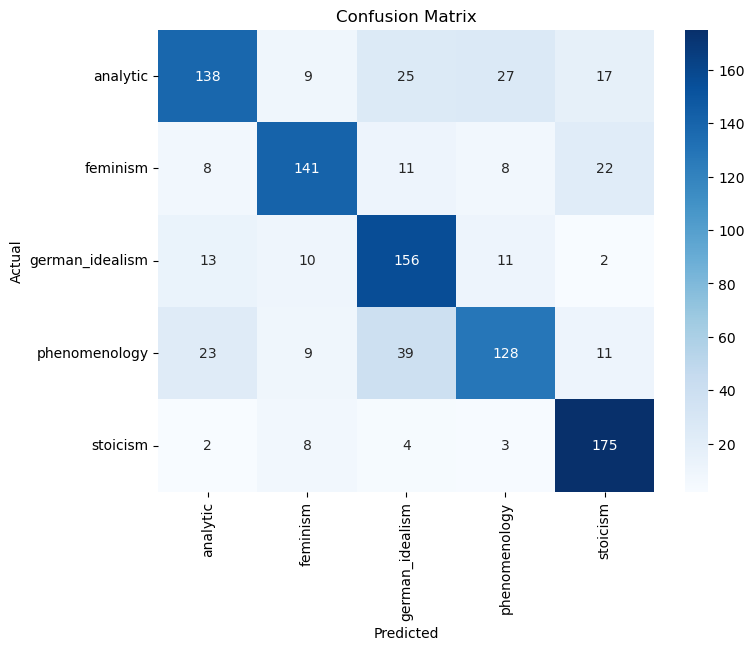

In [46]:
#get unique labels - without this is was changing labels with each run
labels = sorted(list(set(y_test) | set(y_pred)))  

# Compute confusion matrix with fixed label order
cm = confusion_matrix(y_test, y_pred, labels=labels)

# Plot
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


* German Idealism is frequently overpredicted (especially for Phenomenology and Analytic)
* Phenomenology and Analytic are often confused, reflecting shared structures
* Stoicism and Feminism occasionally misclassified as each other, suggesting overlap

Instances where the model predicted german_idealism when the true class was phenomenology (39 instances total):

In [47]:
#make sure y_test and y_pred are arrays
y_test_array = np.array(y_test)
y_pred_array = np.array(y_pred)

#create mask for misclassifications
mask = (y_test_array == "phenomenology") & (y_pred_array == "german_idealism")

#extract the original text for those mistakes
mistakes_df = X_test[mask].copy()
mistakes_df = pd.DataFrame(mistakes_df)
mistakes_df["true_label"] = y_test_array[mask]
mistakes_df["predicted_label"] = y_pred_array[mask]

pd.set_option('display.max_colwidth', None)
mistakes_df.head(10)


,lemmatized_clean,true_label,predicted_label
3021,discoveredness preserve express,phenomenology,german_idealism
3049,condition limit impose self evidence first fall away current pseudo concept set aside,phenomenology,german_idealism
3150,hand mere object rather together unity immediate driving common theoretical interest get know one another observingly take note act thought act experience possibly act objective fact disinterestedly without join perform act without critically assent take exception,phenomenology,german_idealism
3107,also full possession essence clearly imagine color,phenomenology,german_idealism
3968,first case body thing concrete relationship express term top bottom right leave near far may appear irreducibly manifold variety whereas second case discover single indivisible ability trace space,phenomenology,german_idealism
3580,lead thesis substance human existence,phenomenology,german_idealism
3794,spectacle protract suddenly change appearance face take utterly unnatural aspect expression become terrifying eyelash eyebrow assume air materiality never see,phenomenology,german_idealism
3789,mathematical method construct intuitive representation ideal object teach deal operatively systematically,phenomenology,german_idealism
3274,represent consciousness cut something cut add,phenomenology,german_idealism
3276,universally consider historicity human existence communal form historical stage see a. read es wechseln es wechselt,phenomenology,german_idealism


Compare with true german idealism class examples: 

In [48]:
#show gi texts (lemmatized) 
gi_texts = phil[phil['school'] == 'german_idealism']['lemmatized_clean']
gi_texts = pd.DataFrame(gi_texts)
pd.set_option('display.max_colwidth', None)
gi_texts.head(10)

,lemmatized_clean
2000,prescription Verordnung moral law respect body rational outside one hand consider negatively prohibition positively command
2001,depart empirical use constitutive principle nevertheless secure regulative use objective validity
2002,contrary Notion strip trace root branch leave still adhere form purifie latter shape crystal straight line flat surface raise incommensurable ratio ensoulment organic take abstract form understanding time essential nature incommensurability preserve Understanding
2003,since Hume perhaps ingenious skeptic controvertibly preeminent one regard influence skeptical procedure awaken thorough examination reason well worth trouble make clear extent appropriate aim path inference aberration insightful valuable man nevertheless begin trail truth
2004,service may require child therefore contribute solely end upbringing must claim justify right fiir sidl unethical relationship
2005,I.e. one make assumption
2006,unified indivisible suppose active act upon object without doubt
2007,respect without yet consider distinction external internal purposiveness connection purpose general prove truth mechanism
2008,determination stand result moment see
2009,girl concern find husband man find wife


Phenomenology and German Idealism have similar writing styles and words used. I think the main issue is that GI is pretty generalizable to many different writing styles and philosophicial topics. 

In [49]:
#classification report
print("Classification Report:\n")
print(classification_report(y_test, y_pred, digits=4))

Classification Report:

                 precision    recall  f1-score   support

       analytic     0.7500    0.6389    0.6900       216
       feminism     0.7966    0.7421    0.7684       190
german_idealism     0.6638    0.8125    0.7307       192
  phenomenology     0.7232    0.6095    0.6615       210
       stoicism     0.7709    0.9115    0.8353       192

       accuracy                         0.7380      1000
      macro avg     0.7409    0.7429    0.7372      1000
   weighted avg     0.7407    0.7380    0.7346      1000



- analytic (3rd place)
* Precision = 0.75 → 75% of predictions labeled "analytic" were correct.
* Recall = 0.6389 → The model correctly identified ~64% of all actual "analytic" instances.
* F1-score = 0.69 → Moderate performance; recall is weaker than precision.

- feminism (2nd place)
* Precision = 0.7966 → ~80% of predictions labeled "feminism" were correct.
* Recall = 0.7421 → The model found ~74% of all actual feminism instances.
* F1-score = 0.7684 → Pretty solid balance.

- german_idealism (5th place)
* Precision = 0.6638 → Only ~66% of predicted german_idealism are correct.
* Recall = 0.8125 → But the model caught ~81% of actual german_idealism texts.
* F1-score = 0.7307 → High recall, lower precision → model tends to over-predict this class.

- phenomenology (4th place)
* Precision = 0.7232 → ~72% correct predictions.
* Recall = 0.6095 → Only ~61% of actual phenomenology texts were found.
* F1-score = 0.6615 → Performance is moderate; recall is the weak point.

- stoicism (1st place)
* Precision = 0.7709 → 77% of predicted stoicism are correct.
* Recall = 0.9115 → Very high; the model caught ~91% of all stoicism texts.
* F1-score = 0.8353 → Best class performance overall.


# Conclusions

Takeaways

* It is indeed possible to use modeling to separate philosophical texts into their respective schools
* Despite similarities between some of the texts (particularly Phenomenology, German Idealism, and Analytic) several models were still reasonably capable of identifying distinct patterns
* Naive Bayes and Logistic Regression performed the best, bagging and boosting methods did not improve performance in this context
* TF-IDF and Count Vectorizers on lemmatized tokens performed the best and were closely comparable to each other, while n-grams performed poorly across all models
* Working with text introduced many challenges and a greater number of parameters than previous mini porjects, highlighting the complexity of NLP preprocessing and modeling

Suggestions for Further Analysis
* Explore Random Forest parameter tuning to address potential overfitting
* Spend more time optimizing LDA parameters and consider using topic distributions as a feature in modeling
* Consider removing more generalized analytic writing “stop words” that are common in philisophical texts such as:
one, two, first, give, provide, analyze, important, consider, result, example
* Repeat the analysis using full text without lemmatization, stop word removal, or punctuation stripping to evaluate how preprocessing choices affect model performance